<a href="https://colab.research.google.com/github/chandagrover/Machine-Learning/blob/master/2SMILEVAEGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Installs and**

In [1]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-09-21 08:43:41--  https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh [following]
--2020-09-21 08:43:41--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.3-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  84.75M   203MB/s    in 0.4s    

2020-09-21 08:43:41 (203 MB/s) - ‘Minicon

In [2]:
# General Imports
import os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import re

# **SMILES Data Fetching From Zinc Database**

In [3]:
WEIGHTS_FOLDER = 'sample_data/weights/'
smifile = "sample_data/AAAA.smi"
data = pd.read_csv(smifile, delimiter = " ", names = ["smiles","zinc_id"])
NUM_SMILES = len(data)
data["smiles"].head()


0                                     smiles
1                 Cn1cnc2c1c(=O)n(C)c(=O)n2C
2    O=C(O)[C@@H]1/C(=C/CO)O[C@@H]2CC(=O)N21
3                   Cn1c2nncnc2c(=O)n(C)c1=O
4                 Cn1cnc2c1c(=O)[nH]c(=O)n2C
Name: smiles, dtype: object

In [4]:
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"])
print(smiles_train.shape)
print(smiles_test.shape)
print(NUM_SMILES)

(2844,)
(948,)
3792


In [5]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
# embed = max([len(smile) for smile in data.smiles]) + 5
embed = max([len(smile) for smile in data.smiles])+2
print(char_to_int)
print(len(charset), embed)
print(embed)

{'6': 0, '=': 1, 'F': 2, 'N': 3, '#': 4, 'm': 5, '[': 6, '!': 7, 'l': 8, '1': 9, ')': 10, 'o': 11, 'H': 12, '-': 13, '(': 14, '5': 15, 'B': 16, 'S': 17, 'P': 18, '+': 19, '/': 20, '3': 21, 'C': 22, '2': 23, 'c': 24, '4': 25, '\\': 26, ']': 27, 's': 28, 'n': 29, 'e': 30, 'i': 31, 'O': 32, '@': 33, 'E': 34}
35 58
58


In [6]:
print(type(smiles_train))
print(smiles_train.values[0])
print(len(smiles_train.values[0]))
print(type(smiles_train.values[0]))

<class 'pandas.core.series.Series'>
C[C@H]1NC2(COC2)CNC1=O
22
<class 'str'>


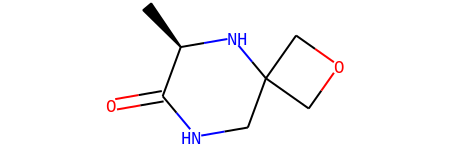

In [7]:
from rdkit.Chem.Draw import IPythonConsole
m = Chem.MolFromSmiles(smiles_train.values[0])
m

In [8]:
def vectorize(smiles):
        onehot_flatList=[[]]
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        print(one_hot.shape)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,:,:]

X_train= vectorize(smiles_train.values)
X_test = vectorize(smiles_test.values)

(2844, 58, 35)
(948, 58, 35)


In [9]:
# Going back from vectorized form back to a readable string
strr="".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])
print(strr)
print(len(strr))

# String After Tructation of extra symbols

line = re.sub('[!E]', '', strr)
print(len(line))
print(line)

!C[C@H]1NC2(COC2)CNC1=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
58
22
C[C@H]1NC2(COC2)CNC1=O


In [10]:
mol_size_x=X_train.shape[1]
mol_size_y=X_train.shape[2]
orig_dim = mol_size_x * mol_size_y
print(mol_size_x)
print(mol_size_y)
print(orig_dim)

58
35
2030


In [11]:
X_train = np.reshape(X_train, [-1, orig_dim])
X_test = np.reshape(X_test, [-1, orig_dim])
print(type(X_train))
print(X_train.shape)
print(X_train.shape[1])

<class 'numpy.ndarray'>
(2844, 2030)
2030


# **Building VAE Model Architecture**

In [12]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.losses import mse, binary_crossentropy

In [13]:
# Network Parameters
INPUT_DIM=(orig_dim,)   # SMILES dimension
intermediate_dim=512
BATCH_SIZE=5
Z_DIM=20 # Dimension of the latent vector (z)
epochs=50

### **Building the Encoder**

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2030)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          1039872     encoder_input[0][0]              
__________________________________________________________________________________________________
mu (Dense)                      (None, 20)           10260       dense[0][0]                      
__________________________________________________________________________________________________
log_var (Dense)                 (None, 20)           10260       dense[0][0]                      
_______________________________________________________________________________________

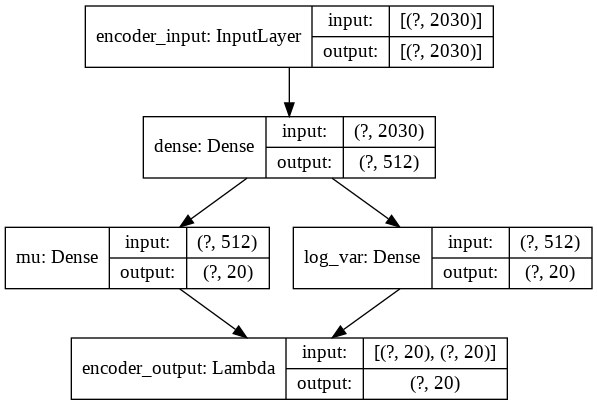

In [14]:
# ENCODER
def build_vae_encoder(input_dim, output_dim):
  
  # Clear tensorflow session to reset layer
  global K
  K.clear_session()
  
  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  
  #Intermediate layer
  x = Dense(intermediate_dim,activation='relu')(encoder_input)
 
  #Model Output
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, output_shape=(Z_DIM,), name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, Model(encoder_input, encoder_output)

vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                                                                            output_dim = Z_DIM)
vae_encoder.summary()
# Plot the Encoder Model
plot_model(vae_encoder, to_file='smilesvae_encoder.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [15]:
print(type(vae_encoder_input))
print(type(vae_encoder_output))
print(type(vae_encoder))


<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.keras.engine.functional.Functional'>



### **Building the Decoder**

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 20)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               10752     
_________________________________________________________________
dense_2 (Dense)              (None, 2030)              1041390   
Total params: 1,052,142
Trainable params: 1,052,142
Non-trainable params: 0
_________________________________________________________________


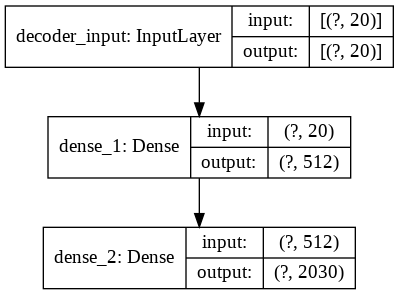

In [16]:

# Decoder
def build_decoder(input_dim, output_dim):

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')
  
  #Intermediate Layer
  x = Dense(intermediate_dim, activation='relu')(decoder_input)

    # Define model output
  decoder_output = Dense(output_dim, activation='sigmoid')(x)


  return decoder_input, decoder_output, Model(decoder_input, decoder_output)


vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM, output_dim=orig_dim)
vae_decoder.summary()
# Plot the Encoder Model
plot_model(vae_decoder, to_file='smilesvae_decoder.png', show_shapes=True, show_layer_names=True, expand_nested=True)

### **Attaching Decoder to the Encoder**

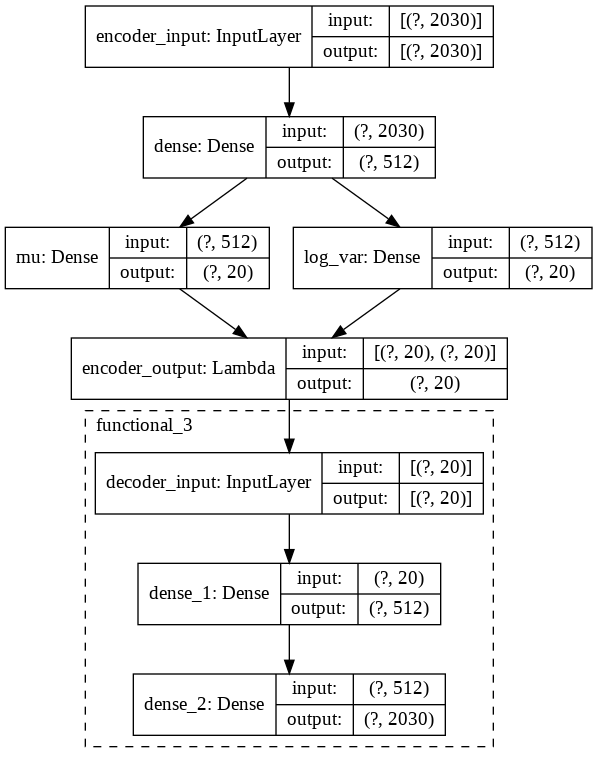

In [17]:
# The input to the model will be the smile string fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)
# Plot the Encoder Model
plot_model(vae_model, to_file='smilesvae_model.png', show_shapes=True, show_layer_names=True, expand_nested=True)

### **Compiling and Training**

In [18]:
if __name__ == '__main__':
    models=(vae_encoder, vae_decoder)
    data=(X_test,X_test)

    reconstruction_loss = binary_crossentropy(vae_input, vae_output)
    reconstruction_loss = reconstruction_loss * orig_dim
    
    kl_loss = 1 + log_var - K.square(mean_mu) - K.exp(log_var)
    kl_loss = K.sum(kl_loss, axis=-1)    
    kl_loss = kl_loss * -0.5
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae_model.add_loss(vae_loss)
    vae_model.compile(optimizer='adam')
    
    
    
#     Train the Variational AutoEncoder
    vae_model.fit(X_train, epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test, None))
    vae_model.save_weights('vae_smiles.h5')
    
    

Epoch 1/50
569/569 [==============================] - 3s 6ms/step - loss: 130.4784 - val_loss: 89.5785
Epoch 2/50
569/569 [==============================] - 3s 5ms/step - loss: 80.2456 - val_loss: 75.7372
Epoch 3/50
569/569 [==============================] - 3s 5ms/step - loss: 70.4209 - val_loss: 69.2195
Epoch 4/50
569/569 [==============================] - 3s 6ms/step - loss: 64.9165 - val_loss: 65.6237
Epoch 5/50
569/569 [==============================] - 3s 6ms/step - loss: 61.3248 - val_loss: 63.6396
Epoch 6/50
569/569 [==============================] - 3s 5ms/step - loss: 58.6611 - val_loss: 61.4037
Epoch 7/50
569/569 [==============================] - 3s 5ms/step - loss: 56.8514 - val_loss: 59.9326
Epoch 8/50
569/569 [==============================] - 3s 5ms/step - loss: 54.8130 - val_loss: 59.1201
Epoch 9/50
569/569 [==============================] - 3s 5ms/step - loss: 53.2334 - val_loss: 58.0391
Epoch 10/50
569/569 [==============================] - 3s 5ms/step - loss: 51.970

In [19]:
reconst_Xtest = vae_model.predict(X_test, batch_size=BATCH_SIZE)
print(type(reconst_Xtest))

<class 'numpy.ndarray'>


### **Reconstructing Test Data Molecules**

In [20]:
reconst_Xtest = vae_model.predict(X_test, batch_size=BATCH_SIZE)
print(type(reconst_Xtest))
print(reconst_Xtest.shape)
print(X_test.shape)
reconst_test = reconst_Xtest.reshape(len(X_test), mol_size_x,mol_size_y)
test=X_test.reshape(len(X_test), mol_size_x, mol_size_y)
print(reconst_test.shape)
print(test.shape)

<class 'numpy.ndarray'>
(948, 2030)
(948, 2030)
(948, 58, 35)
(948, 58, 35)


!OCC(CO)COEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
58
OCC(CO)CO
9


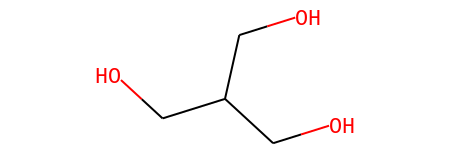

In [21]:
# Going back from vectorized form back to a readable string
idx=15
temp_str="".join([int_to_char[idx] for idx in np.argmax(test[idx,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m

!N=C(CN)COEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
58
N=C(CN)CO
9


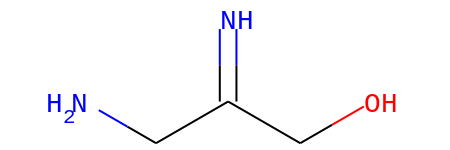

In [22]:
# Going back from vectorized form back to a readable string
temp_str="".join([int_to_char[idx] for idx in np.argmax(reconst_test[idx,:,:], axis=1)])
print(temp_str)
print(len(temp_str))
temp_str = re.sub('!|E',"", temp_str)
print(temp_str)
print(len(temp_str))

m = Chem.MolFromSmiles(temp_str)
m

# **Generating new Molecules from random latent vector sampled from standard normal distribution**

RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: O=C(CO@C(=O)CNO[C1
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'O=C(CO@C(=O)CNO[C1' for input: 'O=C(CO@C(=O)CNO[C1'
RDKit ERROR: [09:28:47] SMILES Parse Error: extra open parentheses for input: 'NC(=O)NCO(NCCC(C)CNC1=O'
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: N[C@@H](CC=NC(@]nn
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'N[C@@H](CC=NC(@]nn' for input: 'N[C@@H](CC=NC(@]nn'
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: C[C@H](O)[C@H]2(CC(N@=O)C(CO)1
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'C[C@H](O)[C@H]2(CC(N@=O)C(CO)1' for input: 'C[C@H](O)[C@H]2(CC(N@=O)C(CO)1'
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: CC(COC[C@@H](C)NH]@H)=O)
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'CC(COC[C@@H](C)NH]@H)=O)' for input: 'CC(COC[C@@H](C)NH]@H)=O)'


RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: O=N1[[HH]c(CO)H](O)[=@)H](O)OO@O
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'O=N1[[HH]c(CO)H](O)[=@)H](O)OO@O' for input: 'O=N1[[HH]c(CO)H](O)[=@)H](O)OO@O'
RDKit ERROR: [09:28:47] SMILES Parse Error: extra close parentheses while parsing: CN1Cnc(C)(=O)O)[)=O)C1
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'CN1Cnc(C)(=O)O)[)=O)C1' for input: 'CN1Cnc(C)(=O)O)[)=O)C1'
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: N[C@@H]1CCS(O)[=O)](OO)OO
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'N[C@@H]1CCS(O)[=O)](OO)OO' for input: 'N[C@@H]1CCS(O)[=O)](OO)OO'
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: CC(CO)CC@C[]H]c(=O)N1CO
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'CC(CO)CC@C[]H]c(=O)N1CO' for input: 'CC(CO)CC@C[]H]c(=O)N1CO'
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error wh

RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: N[C@=](C[C@H](NNCC(N)=()O)=O
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'N[C@=](C[C@H](NNCC(N)=()O)=O' for input: 'N[C@=](C[C@H](NNCC(N)=()O)=O'
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: NCCN[C@NC]1](C(=O)C=
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'NCCN[C@NC]1](C(=O)C=' for input: 'NCCN[C@NC]1](C(=O)C='
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: O=C(C=C[C@H][C@=])N(=O)@@H]211O
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'O=C(C=C[C@H][C@=])N(=O)@@H]211O' for input: 'O=C(C=C[C@H][C@=])N(=O)@@H]211O'
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax error while parsing: C[C@HH]CNC(=N)NNC(=O)NC(=O)(
RDKit ERROR: [09:28:47] SMILES Parse Error: Failed parsing SMILES 'C[C@HH]CNC(=N)NNC(=O)NC(=O)(' for input: 'C[C@HH]CNC(=N)NNC(=O)NC(=O)('
RDKit ERROR: [09:28:47] SMILES Parse Error: syntax erro

RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: C=1c((N)c2H](HH](O)[nH][nc21
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'C=1c((N)c2H](HH](O)[nH][nc21' for input: 'C=1c((N)c2H](HH](O)[nH][nc21'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: NC(=O)CC[C@H]())CO)cC=O
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'NC(=O)CC[C@H]())CO)cC=O' for input: 'NC(=O)CC[C@H]())CO)cC=O'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: O1c1NnC@N)c2Cnn1Nn(CO)C
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'O1c1NnC@N)c2Cnn1Nn(CO)C' for input: 'O1c1NnC@N)c2Cnn1Nn(CO)C'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: O=(=O)CC1CH11CC1H]1=
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'O=(=O)CC1CH11CC1H]1=' for input: 'O=(=O)CC1CH11CC1H]1='
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: O=C(O)[C@HH]1C[C[C@H])

RDKit ERROR: [09:28:48] Explicit valence for atom # 8 C, 8, is greater than permitted
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: CN1c(NNC[H]]c((O)[@H@(O)N(=O)OO)O
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'CN1c(NNC[H]]c((O)[@H@(O)N(=O)OO)O' for input: 'CN1c(NNC[H]]c((O)[@H@(O)N(=O)OO)O'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: NC[C@H](CO)O(O)(OO]C@H](O)[C@@H]1O
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'NC[C@H](CO)O(O)(OO]C@H](O)[C@@H]1O' for input: 'NC[C@H](CO)O(O)(OO]C@H](O)[C@@H]1O'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: O=C1cc((O)[=O)n1nO[n1
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'O=C1cc((O)[=O)n1nO[n1' for input: 'O=C1cc((O)[=O)n1nO[n1'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: CN[NC](C)NO(C)C[C@)O)C(=O)O
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'CN[NC](C)NO(C)C

RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: NCC(=@H]1]CCC(=O)C1
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'NCC(=@H]1]CCC(=O)C1' for input: 'NCC(=@H]1]CCC(=O)C1'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: N[C@](]C[C@H]=O)=C)](11OO1
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'N[C@](]C[C@H]=O)=C)](11OO1' for input: 'N[C@](]C[C@H]=O)=C)](11OO1'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: O=C(O)CN=H[C@@1CNNC1=O)CN1
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'O=C(O)CN=H[C@@1CNNC1=O)CN1' for input: 'O=C(O)CN=H[C@@1CNNC1=O)CN1'
RDKit ERROR: [09:28:48] SMILES Parse Error: extra open parentheses for input: 'N=C(O)CNCC(NO(N)c(=O=O)C'
RDKit ERROR: [09:28:48] SMILES Parse Error: unclosed ring for input: 'O=C1OOCC1CCCN1'


RDKit ERROR: [09:28:48] SMILES Parse Error: unclosed ring for input: 'OCCOC[C@H]OOOC1'
RDKit ERROR: [09:28:48] SMILES Parse Error: unclosed ring for input: 'CC(=O)CC(N)cNNCCN1'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: N[[C@H](O)CCNH]OOO
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'N[[C@H](O)CCNH]OOO' for input: 'N[[C@H](O)CCNH]OOO'
RDKit ERROR: [09:28:48] SMILES Parse Error: extra close parentheses while parsing: COC(=O)NN)[@H]((O)=O
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'COC(=O)NN)[@H]((O)=O' for input: 'COC(=O)NN)[@H]((O)=O'
RDKit ERROR: [09:28:48] SMILES Parse Error: extra open parentheses for input: 'CCCC(=NCC(C1)NCC(=O'


RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: N[C@@)]C(COH](O)(O)C)](=O)[(@@H]1O)H
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'N[C@@)]C(COH](O)(O)C)](=O)[(@@H]1O)H' for input: 'N[C@@)]C(COH](O)(O)C)](=O)[(@@H]1O)H'
RDKit ERROR: [09:28:48] SMILES Parse Error: syntax error while parsing: Nc1nn(1(C(=O)N)CO)C(1OC1
RDKit ERROR: [09:28:48] SMILES Parse Error: Failed parsing SMILES 'Nc1nn(1(C(=O)N)CO)C(1OC1' for input: 'Nc1nn(1(C(=O)N)CO)C(1OC1'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: C[C@H](CC@@@]]CO)=O)N=O)OO
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'C[C@H](CC@@@]]CO)=O)N=O)OO' for input: 'C[C@H](CC@@@]]CO)=O)N=O)OO'
RDKit ERROR: [09:28:49] SMILES Parse Error: extra close parentheses while parsing: O=CC)[(=O)(C(C()O)NC1N
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'O=CC)[(=O)(C(C()O)NC1N' for input: 'O=CC)[(=O)(C(C()O)NC1N'
RDKit ERROR: [09:28:49] SMILES Parse Erro

RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: N[C@]1N1C(N)](CO)CC@)N1
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'N[C@]1N1C(N)](CO)CC@)N1' for input: 'N[C@]1N1C(N)](CO)CC@)N1'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: NC(=O)Cc(n(OCO)cnH]n1
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'NC(=O)Cc(n(OCO)cnH]n1' for input: 'NC(=O)Cc(n(OCO)cnH]n1'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: NC(=O)CC(]1(N)(CCCC(C)CO
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'NC(=O)CC(]1(N)(CCCC(C)CO' for input: 'NC(=O)CC(]1(N)(CCCC(C)CO'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: N[C@H]1HC(=O)C11@@C2)[C@H](@@H]@OO
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'N[C@H]1HC(=O)C11@@C2)[C@H](@@H]@OO' for input: 'N[C@H]1HC(=O)C11@@C2)[C@H](@@H]@OO'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing

RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: COC(=O)COC[@@H](N)C(NO)O
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'COC(=O)COC[@@H](N)C(NO)O' for input: 'COC(=O)COC[@@H](N)C(NO)O'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: N=C@N)1C[C@CH12O
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'N=C@N)1C[C@CH12O' for input: 'N=C@N)1C[C@CH12O'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: Cc1n[nH](O)O[nc+c(=O)n[C)H]cO
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'Cc1n[nH](O)O[nc+c(=O)n[C)H]cO' for input: 'Cc1n[nH](O)O[nc+c(=O)n[C)H]cO'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: O=C1N[C@[H]2c(=N)N(CNO)CC=O)C2
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'O=C1N[C@[H]2c(=N)N(CNO)CC=O)C2' for input: 'O=C1N[C@[H]2c(=N)N(CNO)CC=O)C2'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: NCC(C@H

RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: NC(=O)[C@C@(C1CN)C(N)=O
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'NC(=O)[C@C@(C1CN)C(N)=O' for input: 'NC(=O)[C@C@(C1CN)C(N)=O'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: O[C@@H]1(O)[C@H]@O1(C[)O@H](O)[C1
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'O[C@@H]1(O)[C@H]@O1(C[)O@H](O)[C1' for input: 'O[C@@H]1(O)[C@H]@O1(C[)O@H](O)[C1'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: CNCC[C@C](OO)NCO)C1
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'CNCC[C@C](OO)NCO)C1' for input: 'CNCC[C@C](OO)NCO)C1'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: C=C(=OH]=O)[C@@]O
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'C=C(=OH]=O)[C@@]O' for input: 'C=C(=OH]=O)[C@@]O'


RDKit ERROR: [09:28:49] SMILES Parse Error: extra close parentheses while parsing: C=N1(=O)CCN)C(N)cC
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'C=N1(=O)CCN)C(N)cC' for input: 'C=N1(=O)CCN)C(N)cC'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: NCC(O)Cnc1cc(=)nnn1
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'NCC(O)Cnc1cc(=)nnn1' for input: 'NCC(O)Cnc1cc(=)nnn1'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: O=C@HC1[CC[C@C@@H]C@C]CO2H][[@H](1)O@@@
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'O=C@HC1[CC[C@C@@H]C@C]CO2H][[@H](1)O@@@' for input: 'O=C@HC1[CC[C@C@@H]C@C]CO2H][[@H](1)O@@@'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while parsing: O=C1CC(CONC(C)COC]=N1COH
RDKit ERROR: [09:28:49] SMILES Parse Error: Failed parsing SMILES 'O=C1CC(CONC(C)COC]=N1COH' for input: 'O=C1CC(CONC(C)COC]=N1COH'
RDKit ERROR: [09:28:49] SMILES Parse Error: syntax error while pa

RDKit ERROR: [09:28:50] SMILES Parse Error: unclosed ring for input: 'NC(=O)c1nc(CN)n=O'
RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: C[C@H]1[n1])(O)[C@H][O)[1H)O[O))O
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'C[C@H]1[n1])(O)[C@H][O)[1H)O[O))O' for input: 'C[C@H]1[n1])(O)[C@H][O)[1H)O[O))O'
RDKit ERROR: [09:28:50] SMILES Parse Error: extra close parentheses while parsing: CCCCSCN)CCCCC1
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'CCCCSCN)CCCCC1' for input: 'CCCCSCN)CCCCC1'
RDKit ERROR: [09:28:50] SMILES Parse Error: extra close parentheses while parsing: O=CNO)COC=O)NC
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'O=CNO)COC=O)NC' for input: 'O=CNO)COC=O)NC'
RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: NC(C@H]1O)C(O)CO
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'NC(C@H]1O)C(O)CO' for input: 'NC(C@H]1O)C(O)CO'


RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: N[C@NCOC[C@H](=))n=
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'N[C@NCOC[C@H](=))n=' for input: 'N[C@NCOC[C@H](=))n='
RDKit ERROR: [09:28:50] SMILES Parse Error: extra close parentheses while parsing: O=C(=O)CNCC)C)C[C@=O)CO@@(()
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'O=C(=O)CNCC)C)C[C@=O)CO@@(()' for input: 'O=C(=O)CNCC)C)C[C@=O)CO@@(()'
RDKit ERROR: [09:28:50] non-ring atom 3 marked aromatic
RDKit ERROR: [09:28:50] SMILES Parse Error: extra close parentheses while parsing: C[C@@H]CN)[C@1[@H](C(=O)O
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'C[C@@H]CN)[C@1[@H](C(=O)O' for input: 'C[C@@H]CN)[C@1[@H](C(=O)O'
RDKit ERROR: [09:28:50] SMILES Parse Error: extra close parentheses while parsing: COC(=O)[C@H](N)CCCCn)C1
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'COC(=O)[C@H](N)CCCCn)C1' for input: 'COC(=O)[C@H](N)CCCCn)C1'


RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: O[C@H]1(O[C@@H]2C@@H]COO[[C@HC(O)[C@11
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'O[C@H]1(O[C@@H]2C@@H]COO[[C@HC(O)[C@11' for input: 'O[C@H]1(O[C@@H]2C@@H]COO[[C@HC(O)[C@11'
RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: O=C(O)CC1C(c(=O)[(H]cO)C
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'O=C(O)CC1C(c(=O)[(H]cO)C' for input: 'O=C(O)CC1C(c(=O)[(H]cO)C'
RDKit ERROR: [09:28:50] SMILES Parse Error: extra close parentheses while parsing: COC=O)[C@@C(())CCC@H](H)=O)[C@H](O)[C@(])O
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'COC=O)[C@@C(())CCC@H](H)=O)[C@H](O)[C@(])O' for input: 'COC=O)[C@@C(())CCC@H](H)=O)[C@H](O)[C@(])O'
RDKit ERROR: [09:28:50] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: CN1CCC(C(CO)CO)[C1=O
RDKit ERROR: [09:28:50] SMIL

RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: CN1C(=O)C@@H]1(N)CCO1
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'CN1C(=O)C@@H]1(N)CCO1' for input: 'CN1C(=O)C@@H]1(N)CCO1'
RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: O=C1O[C@H]2N@C@H]((C@C[CC@H](@N)](@)]1O
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'O=C1O[C@H]2N@C@H]((C@C[CC@H](@N)](@)]1O' for input: 'O=C1O[C@H]2N@C@H]((C@C[CC@H](@N)](@)]1O'
RDKit ERROR: [09:28:50] SMILES Parse Error: syntax error while parsing: NS(=O)(=O)[c(=O)[n@Hc1=O=O
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'NS(=O)(=O)[c(=O)[n@Hc1=O=O' for input: 'NS(=O)(=O)[c(=O)[n@Hc1=O=O'
RDKit ERROR: [09:28:50] SMILES Parse Error: extra close parentheses while parsing: O=C1C)CCN1C2C[C@@H](C)C[C@@H](O1(O)
RDKit ERROR: [09:28:50] SMILES Parse Error: Failed parsing SMILES 'O=C1C)CCN1C2C[C@@H](C)C[C@@H](O1(O)' for input: 'O=C1C)CCN1C2C[C@@H](C)C[C@@H](O1(O)'
RD

RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: NC[C@@H]1C[C@H](O)[C@H]]OO[C@H]1O
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'NC[C@@H]1C[C@H](O)[C@H]]OO[C@H]1O' for input: 'NC[C@@H]1C[C@H](O)[C@H]]OO[C@H]1O'
RDKit ERROR: [09:28:51] SMILES Parse Error: extra close parentheses while parsing: Cn1c(O))[nH]nc(2)cOccc(nH]1
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'Cn1c(O))[nH]nc(2)cOccc(nH]1' for input: 'Cn1c(O))[nH]nc(2)cOccc(nH]1'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: NC[C@@H]1C@C(O))=(O)[C@@H](O)C(O)O
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'NC[C@@H]1C@C(O))=(O)[C@@H](O)C(O)O' for input: 'NC[C@@H]1C@C(O))=(O)[C@@H](O)C(O)O'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: CNC(=O)C1C(nH]1C(=O)NC1=
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C1C(nH]1C(=O)NC1=' for input: 'CNC(=O)C1C(nH]1C(=O)NC1='
RDKit ERROR

RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: O=C(CO)[C@]1]C(N)[@@Nc2)N1
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'O=C(CO)[C@]1]C(N)[@@Nc2)N1' for input: 'O=C(CO)[C@]1]C(N)[@@Nc2)N1'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: O=C((OC)NCC@C
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'O=C((OC)NCC@C' for input: 'O=C((OC)NCC@C'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: O[C@H](CO[C@HC(O)C@1H]OO
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'O[C@H](CO[C@HC(O)C@1H]OO' for input: 'O[C@H](CO[C@HC(O)C@1H]OO'
RDKit ERROR: [09:28:51] SMILES Parse Error: extra close parentheses while parsing: CC1=C)NCCS(=O)(=O)CCCC1=O
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'CC1=C)NCCS(=O)(=O)CCCC1=O' for input: 'CC1=C)NCCS(=O)(=O)CCCC1=O'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: CN1C(=O)NC@CH]=O)C(=ON
RDKit 

RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: CCC(NC]CO)[C@H]CNCC(O)[CC@H]1OC()O1
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'CCC(NC]CO)[C@H]CNCC(O)[CC@H]1OC()O1' for input: 'CCC(NC]CO)[C@H]CNCC(O)[CC@H]1OC()O1'
RDKit ERROR: [09:28:51] SMILES Parse Error: unclosed ring for input: 'NCC1CNNCCONCCN'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: O=C@C=OC[C(=O)O)CC@@H]OO)C1@
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'O=C@C=OC[C(=O)O)CC@@H]OO)C1@' for input: 'O=C@C=OC[C(=O)O)CC@@H]OO)C1@'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: N[C@]H]CNCc(O)[C@H](2)OO
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'N[C@]H]CNCc(O)[C@H](2)OO' for input: 'N[C@]H]CNCc(O)[C@H](2)OO'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: N[C@H)NCCCc[C@NH(CO)O
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'N[C@H)NCCCc[C@NH(CO)O' f

RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: N[C@H](CNCC@@H](C)C(=O)OO
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'N[C@H](CNCC@@H](C)C(=O)OO' for input: 'N[C@H](CNCC@@H](C)C(=O)OO'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: CNCNC@H](CCCCNCO
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'CNCNC@H](CCCCNCO' for input: 'CNCNC@H](CCCCNCO'
RDKit ERROR: [09:28:51] SMILES Parse Error: extra close parentheses while parsing: N[C@H]1C)C(=O)OOCCO
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'N[C@H]1C)C(=O)OOCCO' for input: 'N[C@H]1C)C(=O)OOCCO'
RDKit ERROR: [09:28:51] SMILES Parse Error: extra close parentheses while parsing: NC(=O)CCCNC(C[C@@H])O)C(C1
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'NC(=O)CCCNC(C[C@@H])O)C(C1' for input: 'NC(=O)CCCNC(C[C@@H])O)C(C1'


RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: C=c1==(=O)NC1CN2c1=
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'C=c1==(=O)NC1CN2c1=' for input: 'C=c1==(=O)NC1CN2c1='
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: CNSC=C(=O)CC@H]1)CCC2)N
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'CNSC=C(=O)CC@H]1)CCC2)N' for input: 'CNSC=C(=O)CC@H]1)CCC2)N'
RDKit ERROR: [09:28:51] SMILES Parse Error: syntax error while parsing: N11(C)[C==O11
RDKit ERROR: [09:28:51] SMILES Parse Error: Failed parsing SMILES 'N11(C)[C==O11' for input: 'N11(C)[C==O11'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O=C(CO([]@[C@CH]CN1CCO)[C@H]]=[CC@H]1O
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O=C(CO([]@[C@CH]CN1CCO)[C@H]]=[CC@H]1O' for input: 'O=C(CO([]@[C@CH]CN1CCO)[C@H]]=[CC@H]1O'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O[C@@H]1CCCC@@H]2N[C@H](C

RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: COC(=O)[[@@H](())CO@H](COO
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'COC(=O)[[@@H](())CO@H](COO' for input: 'COC(=O)[[@@H](())CO@H](COO'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: C[C@]1]CNC(=O)[C](H]CO
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'C[C@]1]CNC(=O)[C](H]CO' for input: 'C[C@]1]CNC(=O)[C](H]CO'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O=c1C[nH]c(=C)Cn1Hc2c2=O)
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O=c1C[nH]c(=C)Cn1Hc2c2=O)' for input: 'O=c1C[nH]c(=C)Cn1Hc2c2=O)'
RDKit ERROR: [09:28:52] SMILES Parse Error: extra close parentheses while parsing: O=C(O)N1CCNCCCO))C1
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O=C(O)N1CCNCCCO))C1' for input: 'O=C(O)N1CCNCCCO))C1'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: CN1c(=@H]=C)O[C@1

RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O=C(C)[C@=]11C
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O=C(C)[C@=]11C' for input: 'O=C(C)[C@=]11C'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O=C(O@H]1CH](H)(C)C1
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O=C(O@H]1CH](H)(C)C1' for input: 'O=C(O@H]1CH](H)(C)C1'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: NCC(O)[C[C@@O)[C@HC(OC(=O)]
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'NCC(O)[C[C@@O)[C@HC(OC(=O)]' for input: 'NCC(O)[C[C@@O)[C@HC(OC(=O)]'
RDKit ERROR: [09:28:52] SMILES Parse Error: extra close parentheses while parsing: O=C(OO)CO)CC@C]H]@O)(O)(CO)]2[C@H])O)
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O=C(OO)CO)CC@C]H]@O)(O)(CO)]2[C@H])O)' for input: 'O=C(OO)CO)CC@C]H]@O)(O)(CO)]2[C@H])O)'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing:

RDKit ERROR: [09:28:52] SMILES Parse Error: extra close parentheses while parsing: O=C(O)CO)c(=OC(=O)O
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O=C(O)CO)c(=OC(=O)O' for input: 'O=C(O)CO)c(=OC(=O)O'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: NC(=O)[C@@H]1NCC@H](N)Cn1
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'NC(=O)[C@@H]1NCC@H](N)Cn1' for input: 'NC(=O)[C@@H]1NCC@H](N)Cn1'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: COC(=O)cC[nc]C((O)CC=O)C
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'COC(=O)cC[nc]C((O)CC=O)C' for input: 'COC(=O)cC[nc]C((O)CC=O)C'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O=C(O)C1CC[C@H]](
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O=C(O)C1CC[C@H]](' for input: 'O=C(O)C1CC[C@H]]('
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O[C@[]@H](C2CNOCO)[C@H](=)[C@O]1O
RDKi

RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: CC(((O)NC1=On(N)CNN
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'CC(((O)NC1=On(N)CNN' for input: 'CC(((O)NC1=On(N)CNN'
RDKit ERROR: [09:28:52] SMILES Parse Error: extra close parentheses while parsing: CNC(=O)CO)C1=)C((CONN1
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)CO)C1=)C((CONN1' for input: 'CNC(=O)CO)C1=)C((CONN1'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: N[C@@H](Cc(=O)CnH]11C1
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'N[C@@H](Cc(=O)CnH]11C1' for input: 'N[C@@H](Cc(=O)CnH]11C1'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O[C@H](CO)C1=OC(1O2O
RDKit ERROR: [09:28:52] SMILES Parse Error: Failed parsing SMILES 'O[C@H](CO)C1=OC(1O2O' for input: 'O[C@H](CO)C1=OC(1O2O'
RDKit ERROR: [09:28:52] SMILES Parse Error: syntax error while parsing: O=C(O)C1cC(CC[C=O)](O)C(n)O
RDKit ERROR: [09

RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: C[C@=O)C)C(@C((O)CNC=O
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'C[C@=O)C)C(@C((O)CNC=O' for input: 'C[C@=O)C)C(@C((O)CNC=O'
RDKit ERROR: [09:28:53] SMILES Parse Error: extra close parentheses while parsing: O=CN1)[C@H]1CC(=O](O)
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'O=CN1)[C@H]1CC(=O](O)' for input: 'O=CN1)[C@H]1CC(=O](O)'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: O=C(O)C1@H](C[C@H](=O)O
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'O=C(O)C1@H](C[C@H](=O)O' for input: 'O=C(O)C1@H](C[C@H](=O)O'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: O=C@1)C1CC(=O)COH]1
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'O=C@1)C1CC(=O)COH]1' for input: 'O=C@1)C1CC(=O)COH]1'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: NCCNC((C(=O)(N
RDKit ERROR: [09:28:53]

RDKit ERROR: [09:28:53] SMILES Parse Error: extra close parentheses while parsing: COC(=O)[C@@H]1O)CCC(N)=O)O
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'COC(=O)[C@@H]1O)CCC(N)=O)O' for input: 'COC(=O)[C@@H]1O)CCC(N)=O)O'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: C[C@H]@H](O))N)CC@)](CS(C)COO)C1
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'C[C@H]@H](O))N)CC@)](CS(C)COO)C1' for input: 'C[C@H]@H](O))N)CC@)](CS(C)COO)C1'
RDKit ERROR: [09:28:53] SMILES Parse Error: duplicated ring closure 1 bonds atom 3 to itself for input: 'OOC(N11[C@@H]2C)CNCCNC1=O'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: O[C@H]1NCCCNCC(O)[C1]C]2O[C@H]1
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'O[C@H]1NCCCNCC(O)[C1]C]2O[C@H]1' for input: 'O[C@H]1NCCCNCC(O)[C1]C]2O[C@H]1'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: N[C=O)NCCC[C@HO)OCC(=O)
RDKit ERROR: [09:28:53] SM

RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: Nc1nc((C)(NN)c(N)nn1C1
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'Nc1nc((C)(NN)c(N)nn1C1' for input: 'Nc1nc((C)(NN)c(N)nn1C1'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: C[C@@H]1C[C@H](O)[C@@)]()O)O
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'C[C@@H]1C[C@H](O)[C@@)]()O)O' for input: 'C[C@@H]1C[C@H](O)[C@@)]()O)O'
RDKit ERROR: [09:28:53] SMILES Parse Error: extra close parentheses while parsing: O=CNC(=O)O=O)O)
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'O=CNC(=O)O=O)O)' for input: 'O=CNC(=O)O=O)O)'
RDKit ERROR: [09:28:53] SMILES Parse Error: extra open parentheses for input: 'O=C1NCN1C[C@H](=NC(=O)'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: OCCCC(=O)N[C[C@@H])[C@@]O1
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'OCCCC(=O)N[C[C@@H])[C@@]O1' for input: 'OCCCC(=O)N[C[C@@H

RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: O=C(CO)[(@H]2O[C@H](O)CO=O)
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'O=C(CO)[(@H]2O[C@H](O)CO=O)' for input: 'O=C(CO)[(@H]2O[C@H](O)CO=O)'
RDKit ERROR: [09:28:53] SMILES Parse Error: extra close parentheses while parsing: N[C@@H]1CCCCC1=O)O
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'N[C@@H]1CCCCC1=O)O' for input: 'N[C@@H]1CCCCC1=O)O'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: NCCC@]1[C@H](O)[OOO)CO[O[]@@H]@OH)1@HO
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'NCCC@]1[C@H](O)[OOO)CO[O[]@@H]@OH)1@HO' for input: 'NCCC@]1[C@H](O)[OOO)CO[O[]@@H]@OH)1@HO'
RDKit ERROR: [09:28:53] SMILES Parse Error: extra open parentheses for input: 'N[C@@H]CNC(=O'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: O=C12CCC[C1(CCNC(CO)N1
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'O=C12CCC[C1(CCNC

RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: C[C@@H](CO)C@H](OCC@
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'C[C@@H](CO)C@H](OCC@' for input: 'C[C@@H](CO)C@H](OCC@'
RDKit ERROR: [09:28:53] SMILES Parse Error: syntax error while parsing: C[C@@H[CCC@(]))COCC@O)(CO[@([C@H]1O
RDKit ERROR: [09:28:53] SMILES Parse Error: Failed parsing SMILES 'C[C@@H[CCC@(]))COCC@O)(CO[@([C@H]1O' for input: 'C[C@@H[CCC@(]))COCC@O)(CO[@([C@H]1O'
RDKit ERROR: [09:28:54] SMILES Parse Error: extra close parentheses while parsing: CC(=O)(O))N[CC@H]1N)1O
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'CC(=O)(O))N[CC@H]1N)1O' for input: 'CC(=O)(O))N[CC@H]1N)1O'
RDKit ERROR: [09:28:54] SMILES Parse Error: extra open parentheses for input: 'NCCNO(NO)CC(=N=O'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: C1C[CNcCN1CcC=O
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'C1C[CNcCN1CcC=O' for input: 'C1C[CNcCN

RDKit ERROR: [09:28:54] SMILES Parse Error: extra close parentheses while parsing: O=c1[nH]ccnCC=C)=O[CnH])N1
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'O=c1[nH]ccnCC=C)=O[CnH])N1' for input: 'O=c1[nH]ccnCC=C)=O[CnH])N1'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: NCC@OH](Cc(=O
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'NCC@OH](Cc(=O' for input: 'NCC@OH](Cc(=O'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: CN1C(=O)[C@H](O)[C@@H](O)1C@@H]O
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'CN1C(=O)[C@H](O)[C@@H](O)1C@@H]O' for input: 'CN1C(=O)[C@H](O)[C@@H](O)1C@@H]O'
RDKit ERROR: [09:28:54] SMILES Parse Error: extra close parentheses while parsing: NNcCn[n@])(=O)(=O)]
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'NNcCn[n@])(=O)(=O)]' for input: 'NNcCn[n@])(=O)(=O)]'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: CC(=O)CC@H]@

RDKit ERROR: [09:28:54] SMILES Parse Error: unclosed ring for input: 'O=C1NCN1CNCCO1'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: CCCC(]O)NCCO@]O)[C@H]1OOC@O
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'CCCC(]O)NCCO@]O)[C@H]1OOC@O' for input: 'CCCC(]O)NCCO@]O)[C@H]1OOC@O'
RDKit ERROR: [09:28:54] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: OCc[[@H]((N[C1H]1CC[@H]1
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'OCc[[@H]((N[C1H]1CC[@H]1' for input: 'OCc[[@H]((N[C1H]1CC[@H]1'
RDKit ERROR: [09:28:54] SMILES Parse Error: ring closure 1 duplicates bond between atom 3 and atom 5 for input: 'CNC=N12(O)C1OCC1=C1=O'


RDKit ERROR: [09:28:54] SMILES Parse Error: extra close parentheses while parsing: NC(=O)C1=O)CCC1
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'NC(=O)C1=O)CCC1' for input: 'NC(=O)C1=O)CCC1'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: O=C(=O)[n1nc]c))On
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'O=C(=O)[n1nc]c))On' for input: 'O=C(=O)[n1nc]c))On'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: CNC(=O)C@H]1CCNC1=O)NO1
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'CNC(=O)C@H]1CCNC1=O)NO1' for input: 'CNC(=O)C@H]1CCNC1=O)NO1'
RDKit ERROR: [09:28:54] SMILES Parse Error: extra close parentheses while parsing: O=C1ncCcCC)[C@H]2c=O)[1CH]O
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'O=C1ncCcCC)[C@H]2c=O)[1CH]O' for input: 'O=C1ncCcCC)[C@H]2c=O)[1CH]O'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: O[C@@H]1O[C(C](OCCO[(@OH]1
RDKit 

RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: CN(C@CS(O)C(NC)SNC(=OO
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'CN(C@CS(O)C(NC)SNC(=OO' for input: 'CN(C@CS(O)C(NC)SNC(=OO'
RDKit ERROR: [09:28:54] SMILES Parse Error: syntax error while parsing: NC1=c=c=Oc[nO]c2=CCNC11
RDKit ERROR: [09:28:54] SMILES Parse Error: Failed parsing SMILES 'NC1=c=c=Oc[nO]c2=CCNC11' for input: 'NC1=c=c=Oc[nO]c2=CCNC11'
RDKit ERROR: [09:28:55] SMILES Parse Error: extra close parentheses while parsing: NCC=O)O)NC@HH]1=
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'NCC=O)O)NC@HH]1=' for input: 'NCC=O)O)NC@HH]1='
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: O[C@C=NC(=O)OC)[C@H](O
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'O[C@C=NC(=O)OC)[C@H](O' for input: 'O[C@C=NC(=O)OC)[C@H](O'
RDKit ERROR: [09:28:55] SMILES Parse Error: extra open parentheses for input: 'NC(CO)CCN[C@H](NC(=O)C1'


RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: O=C1+]([)O[C@@H][O)[H]1C((C2N=[C@)]1
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'O=C1+]([)O[C@@H][O)[H]1C((C2N=[C@)]1' for input: 'O=C1+]([)O[C@@H][O)[H]1C((C2N=[C@)]1'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: OC[C@=](O)C(=O)NO
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'OC[C@=](O)C(=O)NO' for input: 'OC[C@=](O)C(=O)NO'
RDKit ERROR: [09:28:55] SMILES Parse Error: extra open parentheses for input: 'OCCC1CC(=O)C(CCCNCC1'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: O=C1NNCC(1c=O)n1=O[nH
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'O=C1NNCC(1c=O)n1=O[nH' for input: 'O=C1NNCC(1c=O)n1=O[nH'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: CC(=O)[C@@]](O)CO
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'CC(=O)[C@@]](O)CO' for input: 'CC(=O)[C@@]](O)CO'


RDKit ERROR: [09:28:55] SMILES Parse Error: extra open parentheses for input: 'CNC(=O)C(=CO/NCS(C(=O)O)'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: CS(=O)(=)[C@@1(C(CO(OO)C
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'CS(=O)(=)[C@@1(C(CO(OO)C' for input: 'CS(=O)(=)[C@@1(C(CO(OO)C'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: COC(=O)C[C@@H](O)CC(H])C=C1H
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'COC(=O)C[C@@H](O)CC(H])C=C1H' for input: 'COC(=O)C[C@@H](O)CC(H])C=C1H'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: C=c1[nH]c(NCCOnHc(CO[[@H]]1O
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'C=c1[nH]c(NCCOnHc(CO[[@H]]1O' for input: 'C=c1[nH]c(NCCOnHc(CO[[@H]]1O'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: COC@H]1[[@@H](O)[C@c1(O)[CC@@H](O)[C@@]]()[C@H]1O
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES

RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: N=C(N)CC[C@@=())CC
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'N=C(N)CC[C@@=())CC' for input: 'N=C(N)CC[C@@=())CC'
RDKit ERROR: [09:28:55] SMILES Parse Error: extra open parentheses for input: 'NN1CCC(=O)N(COCCO'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: O=C1NC(CN1CCNC[C@)1OCOC[@@H]2CN
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'O=C1NC(CN1CCNC[C@)1OCOC[@@H]2CN' for input: 'O=C1NC(CN1CCNC[C@)1OCOC[@@H]2CN'
RDKit ERROR: [09:28:55] SMILES Parse Error: extra open parentheses for input: 'CN(C)C[C@H](N)(CO=ON1C1'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: CB1C[(H]cB(O[C1c]2]
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'CB1C[(H]cB(O[C1c]2]' for input: 'CB1C[(H]cB(O[C1c]2]'


RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: O=C(O)[C@H](CO)=CCNC@=O(C)H]@H]1O
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'O=C(O)[C@H](CO)=CCNC@=O(C)H]@H]1O' for input: 'O=C(O)[C@H](CO)=CCNC@=O(C)H]@H]1O'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: OCCC@CN]1COCC
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'OCCC@CN]1COCC' for input: 'OCCC@CN]1COCC'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: O=C1@[C1O[C(H]([)[CO)CO)[C@@H](O)[C@@H]1O
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'O=C1@[C1O[C(H]([)[CO)CO)[C@@H](O)[C@@H]1O' for input: 'O=C1@[C1O[C(H]([)[CO)CO)[C@@H](O)[C@@H]1O'
RDKit ERROR: [09:28:55] SMILES Parse Error: syntax error while parsing: NCCC(=C(=O)N[[C@]C(OC1=O
RDKit ERROR: [09:28:55] SMILES Parse Error: Failed parsing SMILES 'NCCC(=C(=O)N[[C@]C(OC1=O' for input: 'NCCC(=C(=O)N[[C@]C(OC1=O'
RDKit ERROR: [09:28:56] SMILES Parse Error:

RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: Nc1cc(N)c(N)c(=)=O)c
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'Nc1cc(N)c(N)c(=)=O)c' for input: 'Nc1cc(N)c(N)c(=)=O)c'
RDKit ERROR: [09:28:56] SMILES Parse Error: unclosed ring for input: 'NCCC21CCNC(=O)N'
RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: NC(=O)[C@@H]@CO2[C@CC(O)=O@
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'NC(=O)[C@@H]@CO2[C@CC(O)=O@' for input: 'NC(=O)[C@@H]@CO2[C@CC(O)=O@'
RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: CNCCOC(C@CC@H][(=CCNNC(C))C1O)1
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'CNCCOC(C@CC@H][(=CCNNC(C))C1O)1' for input: 'CNCCOC(C@CC@H][(=CCNNC(C))C1O)1'
RDKit ERROR: [09:28:56] SMILES Parse Error: extra close parentheses while parsing: NCC=O)C(1c((O)(=)H]nH])C(@H]1O
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'NCC=O)C(1c((O)(=)H]nH])C(@H]1O

RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: COCcHc(CNCnH)N
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'COCcHc(CNCnH)N' for input: 'COCcHc(CNCnH)N'
RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: NCC(O)CC=OCnH
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'NCC(O)CC=OCnH' for input: 'NCC(O)CC=OCnH'
RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: CO[C@@H]1OO[C@O)]OO)(=O)O1
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'CO[C@@H]1OO[C@O)]OO)(=O)O1' for input: 'CO[C@@H]1OO[C@O)]OO)(=O)O1'
RDKit ERROR: [09:28:56] SMILES Parse Error: unclosed ring for input: 'CC(C)1(=O)COC'
RDKit ERROR: [09:28:56] SMILES Parse Error: extra close parentheses while parsing: O=C1O)[C@HC(=O)C
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'O=C1O)[C@HC(=O)C' for input: 'O=C1O)[C@HC(=O)C'


RDKit ERROR: [09:28:56] SMILES Parse Error: extra close parentheses while parsing: CCCC)C1[C@@H]1COCNCCN=O)O)C
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'CCCC)C1[C@@H]1COCNCCN=O)O)C' for input: 'CCCC)C1[C@@H]1COCNCCN=O)O)C'
RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: CC(C)C]N1C[C@@H](O)C@HC(C)=O(O)
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'CC(C)C]N1C[C@@H](O)C@HC(C)=O(O)' for input: 'CC(C)C]N1C[C@@H](O)C@HC(C)=O(O)'
RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: C=CCCC((1O[C@H]2CCCC[C@H](COCCC
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'C=CCCC((1O[C@H]2CCCC[C@H](COCCC' for input: 'C=CCCC((1O[C@H]2CCCC[C@H](COCCC'
RDKit ERROR: [09:28:56] SMILES Parse Error: syntax error while parsing: N[C@]1(CCC@H](N)[C@H]1=N
RDKit ERROR: [09:28:56] SMILES Parse Error: Failed parsing SMILES 'N[C@]1(CCC@H](N)[C@H]1=N' for input: 'N[C@]1(CCC@H](N)[C@H]1=N'


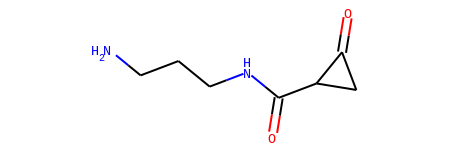

In [44]:
# Generating new Smile Strings sampled from a standard normal distribution
m=None
while m is None:
  reconst_strings = vae_decoder.predict(np.random.normal(0,1,size=(10,Z_DIM)))
  reshaped_string=reconst_strings.reshape(10, mol_size_x, mol_size_y)

  # Going back from vectorized form back to a readable string
  temp_str="".join([int_to_char[idx] for idx in np.argmax(reshaped_string[0,:,:], axis=1)])
  temp_str = re.sub('!|E',"", temp_str)

  m = Chem.MolFromSmiles(temp_str, sanitize=True)
  if m is None:
    print('') #invalid SMILES
  else:
    try:
      Chem.SanitizeMol(m)
    except:
      print('') #invalid chemistry
m



# **Visualizing Latent Space**

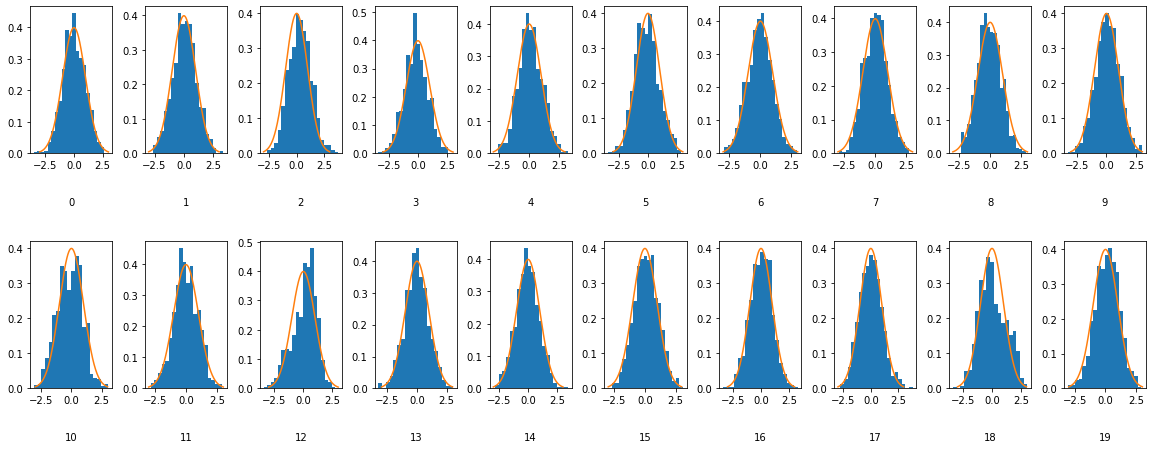

In [24]:
from scipy.stats import norm

z_test = vae_encoder.predict(X_test)

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(20):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('on')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

[[ 0.13326564  1.9844364  -0.21922754 ...  0.9696759   1.1072975
   0.13467588]
 [-1.3844739  -1.9481816  -1.2939259  ... -0.664058    1.8515873
   0.3635982 ]
 [-1.1578335   0.49883235 -0.06301127 ...  0.2617617  -0.59133947
   0.8755739 ]
 ...
 [-1.3613272   0.3504571  -1.089019   ...  1.1404645   1.490412
   0.7800407 ]
 [ 0.6352138   2.43427     0.21110402 ...  0.8287787   1.3367052
   1.3963901 ]
 [ 1.1578147   0.04907709  0.80206585 ... -0.46916103 -0.5397355
   0.90849006]]


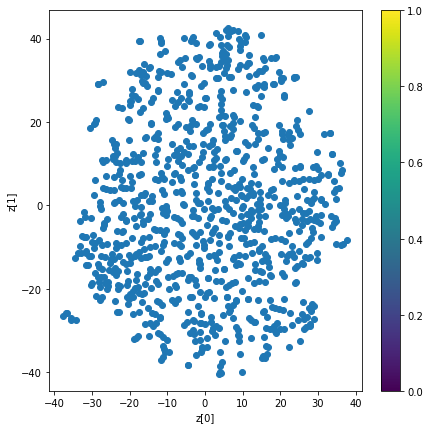

In [25]:
from sklearn.manifold import TSNE
z_mean = vae_encoder.predict(X_test)
print(z_mean)
model_name='VAESMILES_Latent'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "smilesvae_mean.png")

z_embedded = TSNE(n_components=2).fit_transform(z_mean)
plt.figure(figsize=(7,7))
plt.scatter(z_embedded[:, 0], z_embedded[:, 1])
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()

In [26]:
print(z_mean.shape)
print(z_embedded.shape)

(948, 20)
(948, 2)
